# **Question 2b:** Same Question Detection


---


**Imports**

Import needed libraries and download packages "punkt" and "popular"

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import linear_model
import numpy as np
import time
import sys
from sklearn.model_selection import train_test_split
import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from string import digits
import re
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
import os;
import warnings

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('popular')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    | 

True

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read train data in dataframe from csv file.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/University/datasets2020/datasets/q2b/train.csv")
df.head()

,Id,Question1,Question2,IsDuplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Read test data in dataframe from csv file.

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/University/datasets2020/datasets/q2b/test_without_labels.csv")
df_test.head()

,Id,Question1,Question2
0,283003,What can someone do if they've lost the wirele...,What is the best USB wireless mouse that can b...
1,283004,Why India need to elect Prime minister?,Is prime minister of India elected or appointed?
2,283005,How can I make money online with free of cost?,How can I make money online for free?
3,283006,Does MDMA affect the first and higher order mo...,Do antipsychotics affect the first and higher ...
4,283007,"I am a Saudi National and have ""SR 3 million"" ...",Where should I invest money to get high returns?


Discard rows from csv containing NaN values, since these rows cannot actually provide us with any useful knowledge.

In [ ]:
df[df.isnull().any(axis=1)]

,Id,Question1,Question2,IsDuplicate
105780,105780,How can I develop android app?,NaN,0
201841,201841,How can I create an Android app?,NaN,0


In [ ]:
df = df.dropna()
df.shape

(283002, 4)

Graphic representation of duplicate and non duplicate questions in train set data

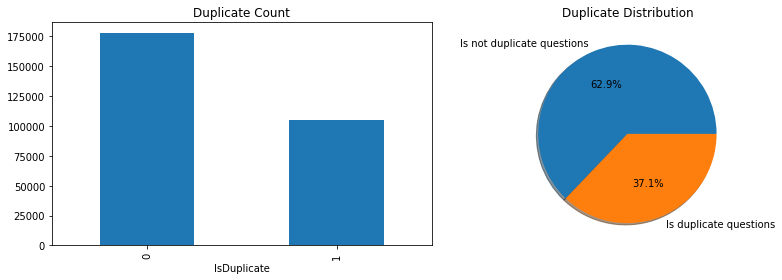

In [ ]:
# Bar chart
plt.subplot(1, 2, 1)
df.groupby('IsDuplicate')['Id'].count().plot.bar()
plt.grid(False)
plt.title('Duplicate Count')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
values = [df[df['IsDuplicate']==0].shape[0], df[df['IsDuplicate']==1].shape[0]]
labels = ['Is not duplicate questions', 'Is duplicate questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Duplicate Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

Find the percentage of unique questions in the dataset.

In [ ]:
qids = pd.Series((df['Question1'].astype(str)).tolist() + (df['Question2'].astype(str)).tolist())
uniq = len(np.unique(qids))
print('Total number of unique questions is {}'.format(uniq))
#Number of questions that repeated than 1 time
cnt = qids.value_counts()
more_than_one = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {}'.format(more_than_one))
print('The maximum number of times a question occured is {}'.format(max(cnt)))

Total number of unique questions is 402690
Number of questions that repeated more than 1 time is 73402
The maximum number of times a question occured is 112


Graphic representation of unique questions in the dataset.

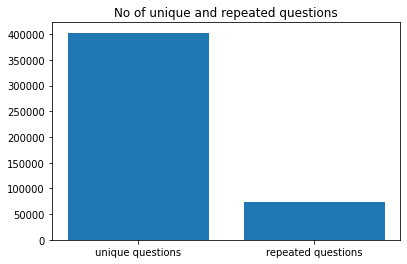

In [ ]:
x = ['unique questions','repeated questions']
y = [uniq, more_than_one]
plt.subplot(1, 2, 1)
plt.bar(x,y)
plt.grid(False)
plt.title('No of unique and repeated questions')
plt.subplots_adjust(right=1.9)

## **Feature Extraction**


---


Before the cleaning process of the data, we proceed to extract from them some features.


*   ***q1len*** = Length of q1
*   ***q2len*** = Length of q2
*   ***q1_n_words*** = Number of words in Question 1
*   ***q2_n_words*** = Number of words in Question 2
*   ***word_Common*** = (Number of common unique words in Question 1 and Question 2)
*   ***word_Total*** =(Total num of words in Question 1 + Total num of words in Question 2)
*   ***word_share*** = (word_common)/(word_Total)




### **Feature extraction - Train data**

In [ ]:
def common_wrd(row):
    x = set(row['Question1'].lower().strip().split(" ")) 
    y = set(row['Question2'].lower().strip().split(" "))
    return 1.0 * len(x & y)

def total(row):
    set1 = set(row['Question1'].lower().strip().split(" "))
    set2 = set(row['Question2'].lower().strip().split(" "))
    return 1.0 * (len(set1) + len(set2))

def word_share(row):
    x = float(row['word_common'])/float(row['word_total'])
    return  x

############################################
#######      Feature Extraction      #######
############################################

#for train data
df['q1len'] = (df['Question1'].astype(str)).apply(lambda x: len(x))
df['q2len'] = (df['Question2'].astype(str)).apply(lambda x: len(x))
df['q1_n_words'] = (df['Question1'].astype(str)).apply(lambda x: len(x.split(" ")))
df['q2_n_words'] = (df['Question2'].astype(str)).apply(lambda x: len(x.split(" ")))
df['q1_n_stopwords'] = df['Question1'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
df['q2_n_stopwords'] = df['Question2'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
df['word_common'] = (df.astype(str)).apply(common_wrd,axis=1)
df['word_total'] = (df.astype(str)).apply(total,axis=1)
df['word_share'] = (df.astype(str)).apply(word_share,axis=1)
df.to_csv("data_with_out_preprocess.csv", index=False)
df.head()

,Id,Question1,Question2,IsDuplicate,q1len,q2len,q1_n_words,q2_n_words,q1_n_stopwords,q2_n_stopwords,word_common,word_total,word_share
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,7,6,10.0,23.0,0.434783
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,4,4.0,20.0,0.200000
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,8,5,4.0,24.0,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,7,4,0.0,19.0,0.000000
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,3,2,2.0,20.0,0.100000


###**Feature extraction - Test data**

In [ ]:
#for test data
df_test['q1len'] = (df_test['Question1'].astype(str)).apply(lambda x: len(x))
df_test['q2len'] = (df_test['Question2'].astype(str)).apply(lambda x: len(x))
df_test['q1_n_words'] = (df_test['Question1'].astype(str)).apply(lambda x: len(x.split(" ")))
df_test['q2_n_words'] = (df_test['Question2'].astype(str)).apply(lambda x: len(x.split(" ")))
df_test['q1_n_stopwords'] = df_test['Question1'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
df_test['q2_n_stopwords'] = df_test['Question2'].apply(lambda x: len([c for c in str(x).lower().split() if c in stopwords.words('english')]))
df_test['word_common'] = (df_test.astype(str)).apply(common_wrd,axis=1)
df_test['word_total'] = (df_test.astype(str)).apply(total,axis=1)
df_test['word_share'] = (df_test.astype(str)).apply(word_share,axis=1)
df_test.to_csv("test_data_with_out_preprocess.csv", index=False)
df_test.head()

,Id,Question1,Question2,q1len,q2len,q1_n_words,q2_n_words,q1_n_stopwords,q2_n_stopwords,word_common,word_total,word_share
0,283003,What can someone do if they've lost the wirele...,What is the best USB wireless mouse that can b...,100,77,17,18,8,11,6.0,34.0,0.176471
1,283004,Why India need to elect Prime minister?,Is prime minister of India elected or appointed?,39,48,7,8,2,3,2.0,15.0,0.133333
2,283005,How can I make money online with free of cost?,How can I make money online for free?,46,37,10,8,5,4,6.0,18.0,0.333333
3,283006,Does MDMA affect the first and higher order mo...,Do antipsychotics affect the first and higher ...,113,121,18,18,5,5,16.0,36.0,0.444444
4,283007,"I am a Saudi National and have ""SR 3 million"" ...",Where should I invest money to get high returns?,148,48,29,9,13,4,3.0,37.0,0.081081


### **Shared words - graphic representation**

We can see below that the shared words increase significantly when the questions are similar. This can be considered as a rise in the probability of two questions being similar, if they share some same words.

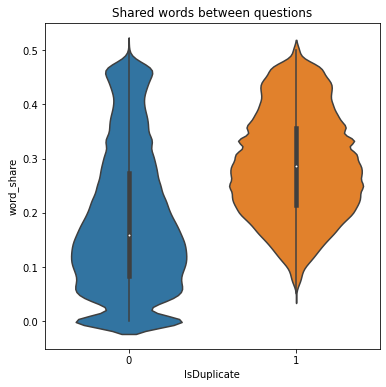

In [ ]:
plt.figure(figsize=(6,6))
sns.violinplot(x='IsDuplicate',y='word_share',data=df)
plt.title('Shared words between questions')
plt.show()

### **Word commoness - Graphic representation** 

In contrast to the shared words depicted in the graph above, we see that the common words between the two questions we compare, seem to be overlapping in both true duplicate questions and non duplicate. Thus, we can not extract any information from this particular feature.

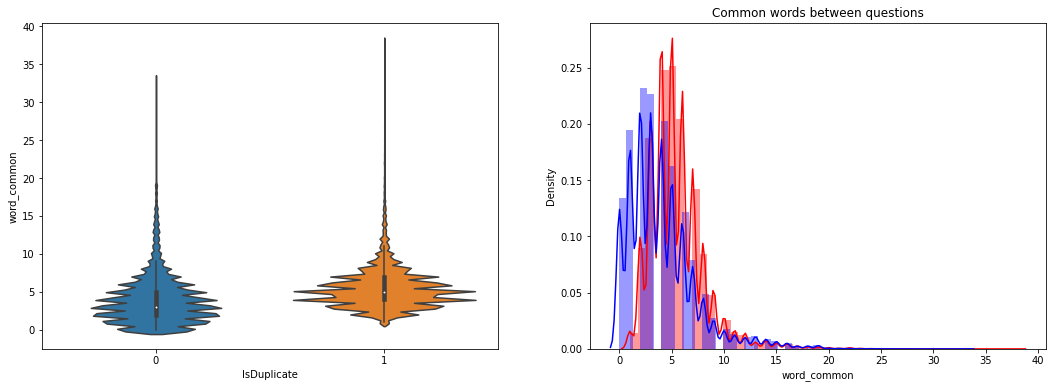

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.violinplot(x='IsDuplicate',y='word_common',data=df)
plt.subplot(1,2,2)
sns.distplot(df[df['IsDuplicate'] == 1]['word_common'],color='red',label='similar')
sns.distplot(df[df['IsDuplicate'] == 0]['word_common'],color='blue',label='disimilar')
plt.title('Common words between questions')
plt.show()

### **Feature correlation matrix**

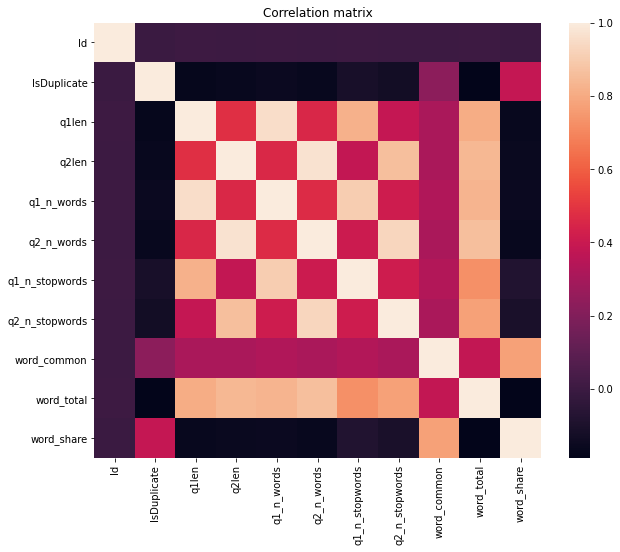

In [ ]:
# Correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

Store train data in csv with extracted features before proceeding with the preprocess

In [ ]:
df = pd.read_csv("/content/data_with_out_preprocess.csv")
df.head() 

,Id,Question1,Question2,IsDuplicate,q1len,q2len,q1_n_words,q2_n_words,q1_n_stopwords,q2_n_stopwords,word_common,word_total,word_share
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,7,6,10.0,23.0,0.434783
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,4,4.0,20.0,0.200000
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,8,5,4.0,24.0,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,7,4,0.0,19.0,0.000000
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,3,2,2.0,20.0,0.100000


Store test data in csv with extracted features before proceeding with the preprocess

In [ ]:
df_test = pd.read_csv("/content/test_data_with_out_preprocess.csv")
df_test.head() 

,Id,Question1,Question2,q1len,q2len,q1_n_words,q2_n_words,q1_n_stopwords,q2_n_stopwords,word_common,word_total,word_share
0,283003,What can someone do if they've lost the wirele...,What is the best USB wireless mouse that can b...,100,77,17,18,8,11,6.0,34.0,0.176471
1,283004,Why India need to elect Prime minister?,Is prime minister of India elected or appointed?,39,48,7,8,2,3,2.0,15.0,0.133333
2,283005,How can I make money online with free of cost?,How can I make money online for free?,46,37,10,8,5,4,6.0,18.0,0.333333
3,283006,Does MDMA affect the first and higher order mo...,Do antipsychotics affect the first and higher ...,113,121,18,18,5,5,16.0,36.0,0.444444
4,283007,"I am a Saudi National and have ""SR 3 million"" ...",Where should I invest money to get high returns?,148,48,29,9,13,4,3.0,37.0,0.081081


## **Data Preprocess**


---

###**Text Data Cleaning**

>For the data cleaning process, we included the following: 
* Remove all special characters and punctuation
* Remove any leading (spaces at the beginning) and trailing (spaces at the end) characters (space is the default leading character to remove)
* Split words
* Lowered all capital letters  

>Both train and test data are preprocessed in the same exact way.

>(reference link: [python-efficient-text-data-cleaning](https://www.geeksforgeeks.org/python-efficient-text-data-cleaning/)

---

### Stemming
>

In [ ]:
def shallow_cleaning(df):
  remove_digits = str.maketrans('', '', digits)
  df['Question1'] = pd.DataFrame(df['Question1'].astype(str)).replace('[^\w\s]', '')
  df['Question1'] = pd.DataFrame(df['Question1'].str.strip())
  df['Question1'] = pd.DataFrame(df['Question1'].str.lower())
  df['Question1'] = pd.DataFrame(df['Question1'].str.split())

  df['Question2'] = pd.DataFrame(df['Question2'].astype(str)).replace('[^\w\s]', ' ')
  df['Question2'] = pd.DataFrame(df['Question2'].str.strip())
  df['Question2'] = pd.DataFrame(df['Question2'].str.lower())
  df['Question2'] = pd.DataFrame(df['Question2'].str.split())
  return df

def stem(df):
  porter = PorterStemmer()
  df['Question1'] = (df['Question1'].astype(str)).apply(lambda x: word_tokenize(x))
  df['Question1'] = df['Question1'].apply(lambda x: [porter.stem(word) for word in x])
  df['Question1'] = df['Question1'].apply(lambda x: ' '.join(str(word) for word in x))

  df['Question2'] = (df['Question2'].astype(str)).apply(lambda x: word_tokenize(x))
  df['Question2'] = df['Question2'].apply(lambda x: [porter.stem(word) for word in x])
  df['Question2'] = df['Question2'].apply(lambda x: ' '.join(str(word) for word in x))
  return df


In [ ]:
df = shallow_cleaning(df)
df_test = shallow_cleaning(df_test)

In [ ]:
df = stem(df)
df_test = stem(df_test)

Store processed train and test data to CSV's

In [ ]:
df_test.to_csv("train_data_processed.csv", index=False)
df_test.to_csv("test_data_processed.csv", index=False)

### **Standardization**
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

All the features extracted earlier from the dataset corpus, is do not necessarily follow the normal distribution curve, which is proved to enhance the algorithms learning  process, as explained in the previous paragraphs.

In [ ]:
# Standardize stats features
from sklearn.preprocessing import StandardScaler

# question length
num_words =  StandardScaler()
X_train_num_words_q1 = num_words.fit_transform(df['q1len'].values.reshape(-1, 1))
X_train_num_words_q2 = num_words.fit_transform(df['q2len'].values.reshape(-1, 1))
X_test_num_words_q1 = num_words.transform(df_test['q1len'].values.reshape(-1, 1))
X_test_num_words_q2 = num_words.transform(df_test['q2len'].values.reshape(-1, 1))


# number of unique words
num_unique_words =  StandardScaler()
X_train_num_unique_words_q1 = num_unique_words.fit_transform(df['q1_n_words'].values.reshape(-1, 1))
X_train_num_unique_words_q2 = num_unique_words.fit_transform(df['q2_n_words'].values.reshape(-1, 1))
X_test_num_unique_words_q1 = num_unique_words.transform(df_test['q1_n_words'].values.reshape(-1, 1))
X_test_num_unique_words_q2 = num_unique_words.transform(df_test['q2_n_words'].values.reshape(-1, 1))


# common words
num_char =  StandardScaler()
X_train_word_common = num_char.fit_transform(df['word_common'].values.reshape(-1, 1))
X_test_word_common = num_char.transform(df_test['word_common'].values.reshape(-1, 1))

# total words
num_char =  StandardScaler()
X_train_word_total = num_char.fit_transform(df['word_total'].values.reshape(-1, 1))
X_test_word_total = num_char.transform(df_test['word_total'].values.reshape(-1, 1))

# shared words
num_char =  StandardScaler()
X_train_word_share = num_char.fit_transform(df['word_share'].values.reshape(-1, 1))
X_test_word_share = num_char.transform(df_test['word_share'].values.reshape(-1, 1))

# number of stopwords
num_stopwords =  StandardScaler()
X_train_num_stopwords_q1 = num_stopwords.fit_transform(df['q1_n_stopwords'].values.reshape(-1, 1))
X_train_num_stopwords_q2 = num_stopwords.fit_transform(df['q2_n_stopwords'].values.reshape(-1, 1))
X_test_num_stopwords_q1 = num_stopwords.transform(df_test['q1_n_stopwords'].values.reshape(-1, 1))
X_test_num_stopwords_q2 = num_stopwords.transform(df_test['q2_n_stopwords'].values.reshape(-1, 1))

#print shapes
print(X_train_num_stopwords_q1.shape, X_train_num_stopwords_q2.shape)
print(X_train_num_unique_words_q1.shape, X_train_num_unique_words_q2.shape)
print(X_train_num_words_q1.shape, X_train_num_words_q2.shape)
print(X_train_word_common.shape)
print(X_train_word_total.shape)
print(X_train_word_share.shape)

(283002, 1) (283002, 1)
(283002, 1) (283002, 1)
(283002, 1) (283002, 1)
(283002, 1)
(283002, 1)
(283002, 1)


Methods for file creation and statistics calculation

In [ ]:
def create_file(data, prediction, filename):
  res_df = pd.DataFrame(data)
  res_df['Predicted'] = prediction
  res_df.to_csv(filename+".csv", columns=['Id', 'Predicted'], index=False)
  return res_df

res_mean = pd.DataFrame([])
res_mean = res_mean.rename_axis('Statistic Measure', axis=1)
columnNum=0
def calculate_statistic_metrics(res, res_mean, columnName, columnNum):
  temp_df = pd.DataFrame([])
  accuracy_mean = pd.Series(res['test_accuracy'].mean(), name='Accuracy')
  precision_mean = pd.Series(res['test_precision_macro'].mean(), name='Precision')
  recall_mean = pd.Series(res['test_recall_macro'].mean(), name='Recall')
  F1_mean = pd.Series(res['test_f1_macro'].mean(), name='F-measure')
  temp_df = temp_df.append(accuracy_mean)
  temp_df = temp_df.append(precision_mean)
  temp_df = temp_df.append(recall_mean)
  temp_df = temp_df.append(F1_mean)
  res_mean[columnName] = temp_df[0]
  res_mean = res_mean.rename(columns={columnNum:columnName})
  return res_mean

Method used to create the Bag of Words.

In [ ]:
def getBOW(df, min_df = 100,ngrams = 1,analyzer = 'word'):
  BOW = TfidfVectorizer( ngram_range=(1,ngrams), lowercase=True, stop_words=stopwords.words('english'))

  bow_df = pd.DataFrame(pd.concat((df['Question1'],df['Question2'])).unique(), columns=['Concatenated'])

  BOW.fit(bow_df['Concatenated'].values.astype('U'))
  print('Vocabulary size is {}'.format(len(BOW.vocabulary_)))
  return BOW

##**Detect Duplicate Questions Task**


---

In general for each classification algorithm, the process we follow is the same. 


1.   Create the bag of words for Question1 and Question2 of the train data 
2.   Stack the aforementioned BoWs along with the extracted features from the test data, in order to create a single array containing all the information we have available.
3. Initialize the classifier of our choice with its specific parameters. The latter were decided after multiple experiments.
4. Apply 5-Fold Cross Validation over the model to evaluate its learning.
5. Fit train data in the model.
6. Make predictions for the test data.




###**Logistic Regression**

>Logistic regression is common and is a useful regression method for solving the binary classification problems like the problem at hand (are questions duplicate or not). It is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem. Its basic fundamental concepts are also constructive in deep learning. Logistic regression describes and estimates the relationship between one dependent binary variable and independent variables.
Some of the properties of Logistic regression are:
*   The dependent variable in logistic regression follows Bernoulli Distribution.
*   Estimation is done through maximum likelihood.
*   No [R Square](https://www.investopedia.com/terms/r/r-squared.asp), Model fitness is calculated through Concordance, [KS-Statistics](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

>**5-Fold Cross Validation:**  
The 5-fold cross validation test for this algorithm
(Logistic Regression) as shown in the statistic measure array above, gives 
accuracy ~79% for the model. The precision (the ratio of correctly predicted 
positive observations to the total predicted positive observations) is ~78% and 
the models recall (the ratio of correctly predicted positive observations to the 
all observations in actual class - yes) is ~76,5%. To catch a better glimpse of 
our models performance, f-measure (the weighted average of Precision and 
Recall) is ~77%. All in all, the predictions that the model ends up making with
 this train data is quite reliable.




In [ ]:
def logisticRegression(min_df = 100,ngrams = 1,analyzer = 'word',train = df, test=df_test):
  start_time = time.time()
  print('BOW and logistic regression')
  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  trainq1_trans = BOW.transform(train['Question1'].values.astype('U'))
  trainq2_trans = BOW.transform(train['Question2'].values.astype('U'))
  labels = train['IsDuplicate'].values

  # stack the train feature arrays horizontally (i.e. column wise) 
  # with the bow of the train data to make a single array
  X = scipy.sparse.hstack((
      trainq1_trans,
      trainq2_trans,
      X_train_num_words_q1,
      X_train_num_words_q2,
      X_train_num_unique_words_q1,
      X_train_num_unique_words_q2,
      X_train_num_stopwords_q1,
      X_train_num_stopwords_q2,
      X_train_word_share,
      X_train_word_common,
      X_train_word_total,
      
  ))
  y = labels

  model = linear_model.LogisticRegression(n_jobs=-1,C=0.5)

  print('5-Fold Cross Validation')
  scoring=['accuracy','precision_macro', 'recall_macro', 'f1_macro']
  scores = cross_validate(model, X, y, cv=5, n_jobs=4, scoring=scoring) 
  lgr_res = pd.DataFrame.from_dict(scores) 
  res = calculate_statistic_metrics(lgr_res, res_mean, 'Logistic Regression', columnNum)       
  
  print('fitting ...')
  model.fit(X,y)

  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  testq1_trans = BOW.transform(test['Question1'].values.astype('U'))
  testq2_trans = BOW.transform(test['Question2'].values.astype('U'))
  
  # stack the test feature arrays horizontally (i.e. column wise) 
  # with the bow of the test data to make a single array
  X_test = scipy.sparse.hstack((
    testq1_trans,
    testq2_trans,
    X_test_num_words_q1,
    X_test_num_words_q2,
    X_test_num_unique_words_q1,
    X_test_num_unique_words_q2,
    X_test_num_stopwords_q1,
    X_test_num_stopwords_q2,
    X_test_word_share,
    X_test_word_common,
    X_test_word_total,
  ))
  
  print('predicting ...')
  y_pred = model.predict(X_test)

  lgr_pred_df = create_file(test, y_pred, 'LGR_pred')

  end_time =time.time()
  print("total time elapsed is {}".format(end_time-start_time))

  return 

logisticRegression(ngrams=3)

BOW and logistic regression
Vocabulary size is 2240231
(283002, 4480471) (283002,)
5-Fold Cross Validation


Statistic Measure,Logistic Regression
Accuracy,0.792645
Precision,0.780977
Recall,0.767595
F-measure,0.772910


fitting ...
Vocabulary size is 2240231
predicting ...
total time elapsed is 574.5763568878174


###**Linear SVM**

>In this experiment we used the Linear SVM classifier with SGD (stochastic gradient descent) training. The estimator [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) implements regularized linear models with SGD learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). We use the default loss function, hinge, which gives a linear SVM and penalty l2 which is the standard regularizer for linear SVM models. 

>**5-Fold Cross Validation:** This classifier gives ~78% accuracy. The precision 
measure, meaning the true positive predictions it makes from the total 
number of positives it returned, is ~77% and the recall (the number of true 
positives divided by the total number of true positives and false negatives) 
is ~76%. All in all, our models has f-measure ~76%, which is quite reasonable.


In [ ]:
def linearSVM(min_df = 100,ngrams = 1,analyzer = 'word',train = df, test = df_test):
  start_time = time.time()
  print('BOW and Linear SVM')
  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  trainq1_trans = BOW.transform(train['Question1'].values.astype('U'))
  trainq2_trans = BOW.transform(train['Question2'].values.astype('U'))
  labels = train['IsDuplicate'].values

  # stack the train feature arrays horizontally (i.e. column wise) 
  # with the bow of the train data to make a single array
  X = scipy.sparse.hstack((
      trainq1_trans,
      trainq2_trans,
      X_train_num_words_q1,
      X_train_num_words_q2,
      X_train_num_unique_words_q1,
      X_train_num_unique_words_q2,
      X_train_num_stopwords_q1,
      X_train_num_stopwords_q2,
      X_train_word_share,
      X_train_word_common,
      X_train_word_total,
      
  ))
  y = labels  

  model = linear_model.SGDClassifier(n_jobs=-1, penalty='l2', loss='hinge')

  print('5-Fold Cross Validation')
  scoring=['accuracy','precision_macro', 'recall_macro', 'f1_macro']
  scores = cross_validate(model, X, y, cv=5, n_jobs=4, scoring=scoring) 
  svm_res = pd.DataFrame.from_dict(scores) 
  res = calculate_statistic_metrics(svm_res, res_mean, 'SVM', columnNum)
  display(res)        
  
  print('fitting ...')
  model.fit(X,y)

  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  testq1_trans = BOW.transform(test['Question1'].values.astype('U'))
  testq2_trans = BOW.transform(test['Question2'].values.astype('U'))

  # stack the test feature arrays horizontally (i.e. column wise) 
  #with the bow of the test data to make a single array
  X_test = scipy.sparse.hstack((
    testq1_trans,
    testq2_trans,
    X_test_num_words_q1,
    X_test_num_words_q2,
    X_test_num_unique_words_q1,
    X_test_num_unique_words_q2,
    X_test_num_stopwords_q1,
    X_test_num_stopwords_q2,
    X_test_word_share,
    X_test_word_common,
    X_test_word_total,
  ))
  print('predicting ...')
  y_pred = model.predict(X_test)

  svm_pred_df = create_file(test, y_pred, 'SVM_pred')

  end_time = time.time()
  print("total time elapsed is {}".format(end_time-start_time))
  
  return 

linearSVM(ngrams=2)

BOW and Linear SVM
Vocabulary size is 932545
5-Fold Cross Validation


Statistic Measure,Logistic Regression,SVM
Accuracy,0.792645,0.783252
Precision,0.780977,0.769909
Recall,0.767595,0.759067
F-measure,0.772910,0.763441


fitting ...
Vocabulary size is 932545
predicting ...
total time elapsed is 77.75392889976501


### **XGBoost**

>[XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) is well known to provide better solutions than other machine learning algorithms. In fact, since its inception, it has become the "state-of-the-art” machine learning algorithm to deal with structured data. XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library. 
Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. Note that a weak learner is one which is slightly better than random guessing. For example, a decision tree whose predictions are slightly better than 50%.

>**5-Fold Cross Validation:** This method returns the accuracy ~80%, which is the 
best of the three tested. The precision is ~79% and the recall (actual 
predicted positives) ~78.5%. Last the f-measure is ~78.5%.


In [ ]:
import xgboost as xgb

In [ ]:
def train_params(min_df = 100,ngrams = 1,analyzer = 'word',train = df, test = df_test):
  start_time = time.time()
  print('BOW and XGBoost')
  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  trainq1_trans = BOW.transform(train['Question1'].values.astype('U'))
  trainq2_trans = BOW.transform(train['Question2'].values.astype('U'))
  labels = train['IsDuplicate'].values

  # stack the train feature arrays horizontally (i.e. column wise) 
  # with the bow of the train data to make a single array
  X = scipy.sparse.hstack((
      trainq1_trans,
      trainq2_trans,
      X_train_num_words_q1,
      X_train_num_words_q2,
      X_train_num_unique_words_q1,
      X_train_num_unique_words_q2,
      X_train_num_stopwords_q1,
      X_train_num_stopwords_q2,
      X_train_word_share,
      X_train_word_common,
      X_train_word_total,    
  ))
  y = labels  

  model =  xgb.XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=6, 
                             min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                             objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, eval_metric='error')
  print('5-Fold Cross Validation')
  scoring=['accuracy','precision_macro', 'recall_macro', 'f1_macro']
  scores = cross_validate(model, X, y, cv=5, n_jobs=-1, scoring=scoring) 
  xgb_res = pd.DataFrame.from_dict(scores) 
  res = calculate_statistic_metrics(xgb_res, res_mean, 'XGB', columnNum)
  display(res)        
  
  print('fitting ...')
  model.fit(X,y)

  BOW = getBOW(train, min_df=min_df,ngrams = ngrams,analyzer = analyzer)
  testq1_trans = BOW.transform(test['Question1'].values.astype('U'))
  testq2_trans = BOW.transform(test['Question2'].values.astype('U'))

  # stack the test feature arrays horizontally (i.e. column wise) 
  # with the bow of the test data to make a single array
  X_test = scipy.sparse.hstack((
    testq1_trans,
    testq2_trans,
    X_test_num_words_q1,
    X_test_num_words_q2,
    X_test_num_unique_words_q1,
    X_test_num_unique_words_q2,
    X_test_num_stopwords_q1,
    X_test_num_stopwords_q2,
    X_test_word_share,
    X_test_word_common,
    X_test_word_total,
  ))
  print('predicting ...')
  y_pred = model.predict(X_test)

  xgb_pred_df = create_file(test, y_pred, 'XGB_pred')

  end_time = time.time()
  print("total time elapsed is {}".format(end_time-start_time))

  return 

train_params(ngrams=1)

BOW and XGBoost
Vocabulary size is 57887
5-Fold Cross Validation


Statistic Measure,Logistic Regression,SVM,XGB
Accuracy,0.792645,0.783252,0.802411
Precision,0.780977,0.769909,0.789027
Recall,0.767595,0.759067,0.785513
F-measure,0.772910,0.763441,0.787161


fitting ...
Vocabulary size is 57887
predicting ...
total time elapsed is 5100.600019931793
